## MCMC for optimizing the 2-layer multiple output Neural Network

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

In [63]:
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

72 CPUs


Testing out some emcee functionality
https://emcee.readthedocs.io/en/v2.2.1/

In [2]:
#def lnprob(x, ivar):
#    return -0.5 * np.sum(ivar * x ** 2)

#ndim, nwalkers = 10, 100
#ivar = 1. / np.random.rand(ndim)
#p0 = [np.random.rand(ndim) for i in range(nwalkers)]

#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
#sampler.run_mcmc(p0, 10)

In [3]:
#[np.random.rand(10) for i in range(10)]

Load previously trained NN models

In [4]:
import keras.backend as K
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)
from keras.models import load_model
model_GPP = load_model('emulators/NN_GPP_finalize_multi-dim.h5', 
                       custom_objects={'mean_sq_err': mean_sq_err})
model_LHF = load_model('emulators/NN_LHF_finalize_multi-dim.h5', 
                       custom_objects={'mean_sq_err': mean_sq_err})

Using TensorFlow backend.
W0821 14:17:04.535356 47459742834176 deprecation_wrapper.py:119] From /gpfs/fs1/work/kdagon/ncar_pylib_clone_20190627/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 14:17:04.573081 47459742834176 deprecation_wrapper.py:119] From /gpfs/fs1/work/kdagon/ncar_pylib_clone_20190627/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 14:17:04.694269 47459742834176 deprecation_wrapper.py:119] From /gpfs/fs1/work/kdagon/ncar_pylib_clone_20190627/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0821 14:17:04.695039 47459742834176 deprecation_wrapper.py:119] From /gpfs/fs1/work/kdagon/ncar_pylib_clone_20190627/lib/python3.6/site-packages

List input variables

In [5]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Read in observational targets and calculated variance

In [6]:
obs_GPP = np.load(file="obs/obs_GPP_SVD_3modes.npy", allow_pickle=True)
obs_LHF = np.load(file="obs/obs_LHF_SVD_3modes.npy", allow_pickle=True)
sd_GPP = np.load(file="obs/obs_GPP_SVD_3modes_allyrs_sd.npy", allow_pickle=True)
sd_LHF = np.load(file="obs/obs_LHF_SVD_3modes_allyrs_sd.npy", allow_pickle=True)

Define normalized error function  

In [7]:
B=1.49 # midpoint of regimes
def normerr(x):
    xt = x.reshape(1,-1)
    model_preds_GPP = model_GPP.predict(xt)
    model_preds_LHF = model_LHF.predict(xt)
    L = -(np.sum(((model_preds_GPP-obs_GPP)/sd_GPP)**2, axis=1) + B*np.sum(((model_preds_LHF-obs_LHF)/sd_LHF)**2, axis=1))
    return L

Define the prior //
see also https://emcee.readthedocs.io/en/v2.2.1/user/line/#marginalization-uncertainty-estimation

In [8]:
def lnprior(x):
    #if x.any() >= 0 and x.any() <= 1:
    if all(x > 0) and all(x < 1):
        return 0.0
    return -np.inf

Define full log prob function

In [9]:
def lnprob(x):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + normerr(x)

Number of walkers, number of dimensions = number of parameters

In [10]:
nwalkers = 200
ndim = npar

Initialize walkers (random initial states)

In [11]:
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

LHC generated random initial conditions

In [12]:
#from pyDOE import *
#lhd = lhs(npar,samples=1) # default sampling criterion = random
#x0 = lhd[0,:]
#print(x0)
#x0.shape
#xt = x0.reshape(1,-1)
#print(xt)
#p0=[x0]
#print(p0)

Set up sampler

In [42]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run Sampler

In [43]:
epochs = 100
sampler.run_mcmc(p0, epochs, progress=True)

100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


State([[0.63102483 0.82488569 0.00580463 0.54553229 0.64401952 0.28249317]
 [0.60301592 0.91805154 0.00142274 0.71520956 0.84635978 0.03402452]
 [0.51543956 0.71807546 0.00697731 0.04045021 0.58638464 0.3258884 ]
 ...
 [0.29219216 0.87358705 0.01280168 0.56836679 0.85527652 0.25914871]
 [0.48171549 0.89586546 0.04068677 0.58792577 0.74888822 0.4218421 ]
 [0.46668375 0.873558   0.00811494 0.70695574 0.93834189 0.35032818]], log_prob=[-16798832. -15942079. -16889670. -16923458. -16407442. -24419238.
 -16137504. -16718570. -16087272. -16786804. -16433330. -25416858.
 -16183888. -16682806. -17544788. -16423719. -17042336. -16121645.
 -16807284. -16441690. -16538795. -16176198. -25238468. -16965454.
 -16618251. -16699383. -16727340. -16546845. -19637268. -25029146.
 -16429854. -16353082. -16104903. -16615248. -17125534. -16187189.
 -16428598. -16555590. -16182090. -16527569. -16881796. -25038528.
 -16636614. -16452620. -16338075. -16671298. -16702080. -16436442.
 -16465356. -24235488. -1682

In [45]:
sampler.chain.shape # nwalkers x epochs x ndim
sampler.chain[0,epochs-1,:] # final values for first walker

array([0.63102483, 0.82488569, 0.00580463, 0.54553229, 0.64401952,
       0.28249317])

Plot results

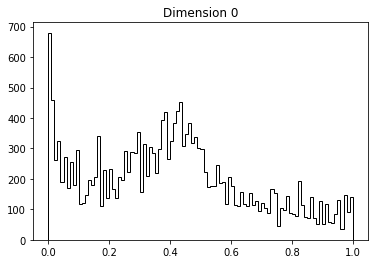

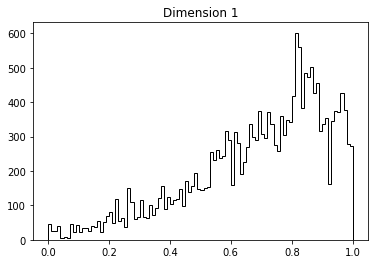

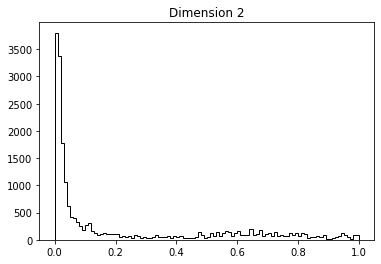

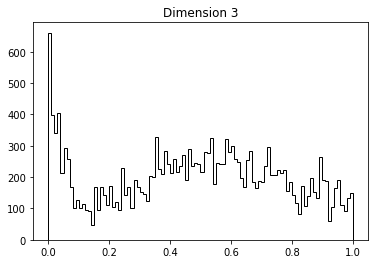

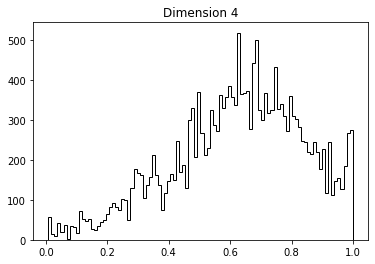

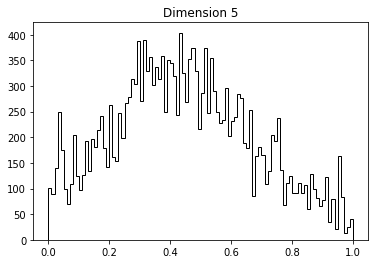

In [46]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))
plt.show()

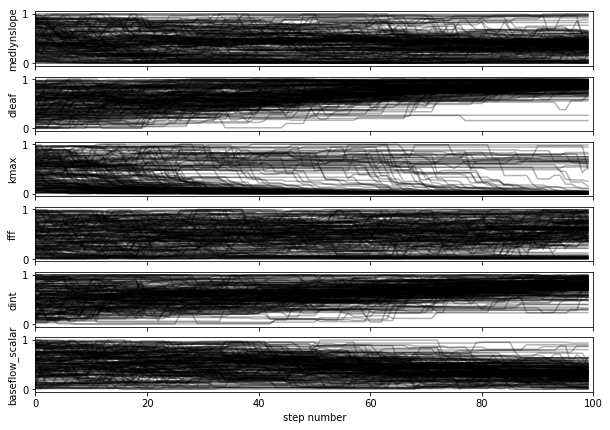

In [47]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_all = sampler.get_chain()
labels = in_vars
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("step number")
plt.show()

In [48]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.215


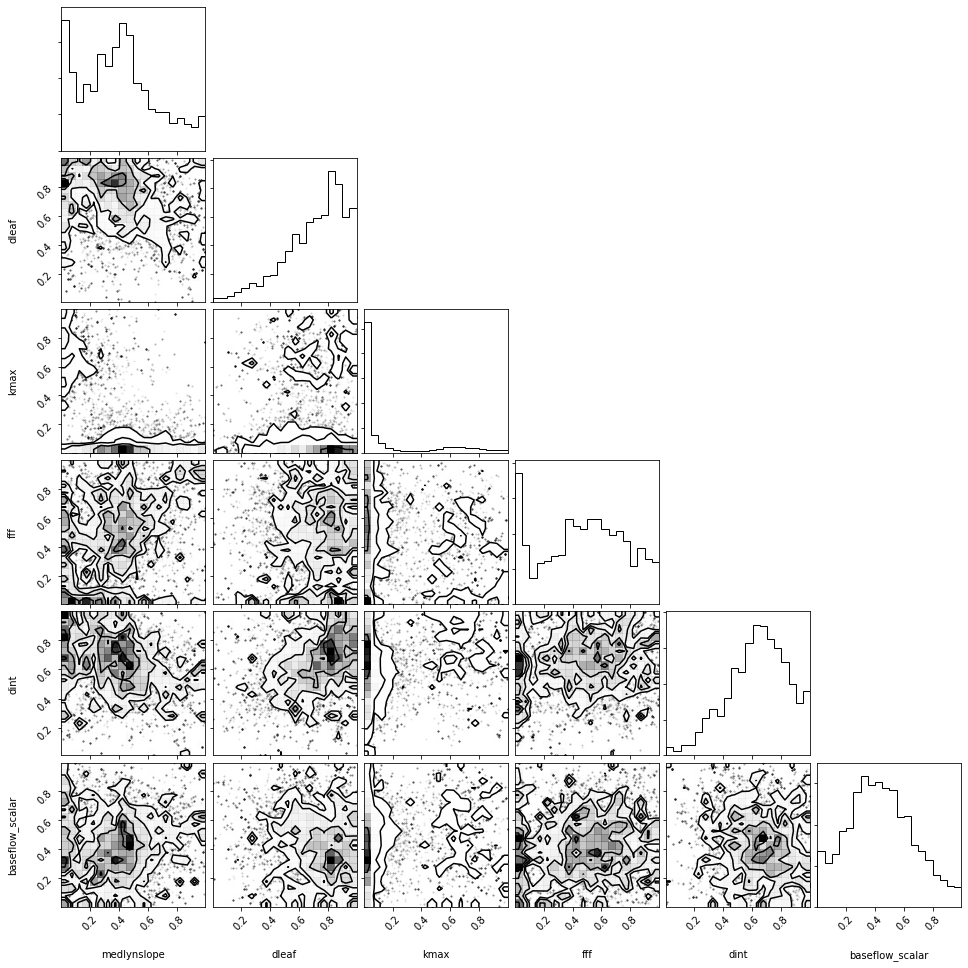

In [49]:
# discard the initial N steps
#samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
flat_samples = sampler.get_chain(discard=10, flat=True)
import corner
fig = corner.corner(flat_samples, labels=in_vars)
#fig.savefig("MCMC_v1.pdf")

Get last sample

In [57]:
#last_sample = sampler.get_last_sample() # can't figure out how to access this data structure
#dir(last_sample)
#last_sample.__class__
#print(last_sample)
last_sample = sampler.chain[:,epochs-1,:] # final values for all walkers
#print(last_sample.shape)
np.save("MCMC_last_sample", last_sample)

(200, 6)


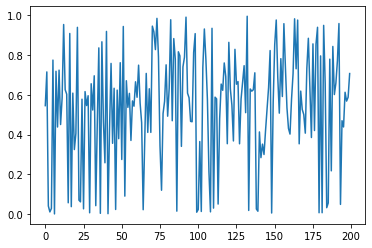

In [62]:
posterior = np.load("MCMC_last_sample.npy")
#posterior.shape
#plt.plot(posterior[:,3])